<a href="https://colab.research.google.com/github/KatieMarsh/STONK/blob/main/Evaluate_model_no_indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
gdd.download_file_from_google_drive(file_id='1H7k6jJ3WJGseLKQIllWUOAsvM3nPdc3R',
                                    dest_path='/model.pkl',
                                    )

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

!pip install pandas_datareader
from pandas_datareader import data as pdr
from tqdm import tqdm_notebook

In [ ]:
stock_list = ['KBANK','SCB','BBL','KTB']
stock_data = []
stock_name = []
for quote in tqdm_notebook(stock_list):
    try:
        stock_data.append(pdr.get_data_yahoo(f'{quote}.BK', start='2019-01-02', end='2021-06-25'))
        stock_name.append(quote)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
stock_data1=stock_data
stock_data2=stock_data

In [ ]:
!pip install bta-lib #try this out
import btalib

In [ ]:
#this part extract indicator from data

sma = btalib.sma(stock_data[0].Close, period=20)  # default period is 30, changed to 20
sma.df.columns = ['SMA']

t3 = btalib.t3(stock_data[0], period=5)
t3.df.columns = ['t3']

atr = btalib.natr(stock_data[0].High,stock_data[0].Low,stock_data[0].Close, period=7)
atr.df.columns = ['atr']

stock_data1 = pd.concat([stock_data1[0],sma.df,t3.df],axis=1) #concat them
stock_data2 = pd.concat([stock_data2[0],atr.df],axis=1)

In [ ]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
    

# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น
dataset = stock_data[0]
dataset = dataset.drop('Close',axis=1)
dataset['pct_change'] = dataset['Adj Close'].pct_change().dropna()
values = dataset.values
values = values.astype('float32')

# ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
#I think this part can be replaced with sigmoid
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())
  
# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 30, 1,feat_name=dataset.columns)

reframed.drop(['High(t)','Low(t)','Open(t)','Volume(t)','Adj Close(t)'],
              axis=1,inplace=True)#แก้ตรงนี้

In [ ]:
reframed.head(5)

,High(t-30),Low(t-30),Open(t-30),Volume(t-30),Adj Close(t-30),pct_change(t-30),High(t-29),Low(t-29),Open(t-29),Volume(t-29),Adj Close(t-29),pct_change(t-29),High(t-28),Low(t-28),Open(t-28),Volume(t-28),Adj Close(t-28),pct_change(t-28),High(t-27),Low(t-27),Open(t-27),Volume(t-27),Adj Close(t-27),pct_change(t-27),High(t-26),Low(t-26),Open(t-26),Volume(t-26),Adj Close(t-26),pct_change(t-26),High(t-25),Low(t-25),Open(t-25),Volume(t-25),Adj Close(t-25),pct_change(t-25),High(t-24),Low(t-24),Open(t-24),Volume(t-24),Adj Close(t-24),pct_change(t-24),High(t-23),Low(t-23),Open(t-23),Volume(t-23),Adj Close(t-23),pct_change(t-23),High(t-22),Low(t-22),Open(t-22),Volume(t-22),Adj Close(t-22),pct_change(t-22),High(t-21),Low(t-21),Open(t-21),Volume(t-21),Adj Close(t-21),pct_change(t-21),High(t-20),Low(t-20),Open(t-20),Volume(t-20),Adj Close(t-20),pct_change(t-20),High(t-19),Low(t-19),Open(t-19),Volume(t-19),Adj Close(t-19),pct_change(t-19),High(t-18),Low(t-18),Open(t-18),Volume(t-18),Adj Close(t-18),pct_change(t-18),High(t-17),Low(t-17),Open(t-17),Volume(t-17),Adj Close(t-17),pct_change(t-17),High(t-16),Low(t-16),Open(t-16),Volume(t-16),Adj Close(t-16),pct_change(t-16),High(t-15),Low(t-15),Open(t-15),Volume(t-15),Adj Close(t-15),pct_change(t-15),High(t-14),Low(t-14),Open(t-14),Volume(t-14),Adj Close(t-14),pct_change(t-14),High(t-13),Low(t-13),Open(t-13),Volume(t-13),Adj Close(t-13),pct_change(t-13),High(t-12),Low(t-12),Open(t-12),Volume(t-12),Adj Close(t-12),pct_change(t-12),High(t-11),Low(t-11),Open(t-11),Volume(t-11),Adj Close(t-11),pct_change(t-11),High(t-10),Low(t-10),Open(t-10),Volume(t-10),Adj Close(t-10),pct_change(t-10),High(t-9),Low(t-9),Open(t-9),Volume(t-9),Adj Close(t-9),pct_change(t-9),High(t-8),Low(t-8),Open(t-8),Volume(t-8),Adj Close(t-8),pct_change(t-8),High(t-7),Low(t-7),Open(t-7),Volume(t-7),Adj Close(t-7),pct_change(t-7),High(t-6),Low(t-6),Open(t-6),Volume(t-6),Adj Close(t-6),pct_change(t-6),High(t-5),Low(t-5),Open(t-5),Volume(t-5),Adj Close(t-5),pct_change(t-5),High(t-4),Low(t-4),Open(t-4),Volume(t-4),Adj Close(t-4),pct_change(t-4),High(t-3),Low(t-3),Open(t-3),Volume(t-3),Adj Close(t-3),pct_change(t-3),High(t-2),Low(t-2),Open(t-2),Volume(t-2),Adj Close(t-2),pct_change(t-2),High(t-1),Low(t-1),Open(t-1),Volume(t-1),Adj Close(t-1),pct_change(t-1),pct_change(t)
31,0.863636,0.877863,0.874286,0.017766,0.873337,0.480940,0.856061,0.866412,0.866667,0.042209,0.873337,0.463977,0.871212,0.881679,0.870476,0.032794,0.889170,0.497721,0.871212,0.885496,0.881905,0.014497,0.877295,0.438939,0.871212,0.885496,0.878095,0.029063,0.873337,0.455564,0.863636,0.828244,0.874286,0.087441,0.825838,0.362746,0.829545,0.843511,0.836190,0.028935,0.837713,0.490129,0.825758,0.843511,0.836190,0.013664,0.833755,0.455332,0.833333,0.847328,0.836190,0.013365,0.841671,0.481315,0.833333,0.847328,0.843810,0.016806,0.849587,0.481220,0.852273,0.858779,0.847619,0.053244,0.861462,0.489700,0.859848,0.851145,0.870476,0.099554,0.849587,0.438463,0.878788,0.870229,0.862857,0.088294,0.885211,0.541145,0.878788,0.881679,0.878095,0.044628,0.897086,0.489083,0.897727,0.904580,0.897143,0.111406,0.908961,0.488883,0.905303,0.904580,0.912381,0.063811,0.924794,0.496924,0.920455,0.938931,0.927619,0.042270,0.932710,0.480280,0.916667,0.931298,0.931429,0.025924,0.928752,0.455868,0.912879,0.931298,0.920000,0.014839,0.932710,0.472107,0.909091,0.927481,0.923810,0.037049,0.928752,0.455868,0.962121,0.950382,0.939048,0.095880,0.984167,0.577797,0.977273,0.984733,0.984762,0.051925,0.992084,0.479668,0.984848,0.992366,0.984762,0.017400,1.000000,0.479590,0.977273,0.984733,0.984762,0.009041,0.984167,0.432906,0.984848,0.992366,0.984762,0.028253,1.000000,0.495359,1.000000,1.000000,1.000000,0.051189,1.000000,0.463977,0.969697,0.973282,0.969524,0.067370,0.976251,0.417371,0.946970,0.958015,0.958095,0.065876,0.952501,0.416668,0.950758,0.961832,0.950476,0.014441,0.960418,0.479988,0.950758,0.965649,0.965714,0.017070,0.960418,0.463977,0.463977
32,0.856061,0.866412,0.866667,0.042209,0.873337,0.463977,0.871212,0

In [ ]:
# split into train and test sets
n_train_percent = 0.0

split = int(reframed.shape[0]*n_train_percent)
df_seq_test = reframed.iloc[split:, :]

date_all = dataset.index[reframed.index]

In [ ]:
df_dt = pd.DataFrame({'date_time':date_all})

In [ ]:
df_dt_feat = pd.concat([df_dt.date_time.dt.day, df_dt.date_time.dt.dayofweek, df_dt.date_time.dt.dayofyear,\
                           df_dt.date_time.dt.daysinmonth, df_dt.date_time.dt.is_month_end,df_dt.date_time.dt.is_month_start,\
                           df_dt.date_time.dt.is_quarter_end, df_dt.date_time.dt.is_quarter_start, df_dt.date_time.dt.is_year_end,\
                           df_dt.date_time.dt.is_year_start],axis=1)
df_dt_feat.columns = ['day','dayofweek','dayofyear','daysinmonth','is_month_end','is_month_start','is_quarter_end','is_quarter_start',\
                        'is_year_end','is_year_start']

In [ ]:
df_dt_feat['is_month_end'] = df_dt_feat['is_month_end'].astype(int)
df_dt_feat['is_month_start'] = df_dt_feat['is_month_start'].astype(int)
df_dt_feat['is_quarter_end'] = df_dt_feat['is_quarter_end'].astype(int)
df_dt_feat['is_quarter_start'] = df_dt_feat['is_quarter_start'].astype(int)
df_dt_feat['is_year_end'] = df_dt_feat['is_year_end'].astype(int)
df_dt_feat['is_year_start'] = df_dt_feat['is_year_start'].astype(int)

In [ ]:
# encode categorical columns
for col in ['day','dayofweek','dayofyear','daysinmonth']:
  df_dt_feat[col] = df_dt_feat[col].astype('category').cat.as_ordered().cat.codes

In [ ]:
df_dt_feat.head()

,day,dayofweek,dayofyear,daysinmonth,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,13,3,43,0,0,0,0,0,0,0
1,14,4,44,0,0,0,0,0,0,0
2,17,0,47,0,0,0,0,0,0,0
3,19,2,49,0,0,0,0,0,0,0
4,20,3,50,0,0,0,0,0,0,0


In [ ]:
df_dt_feat_train = df_dt_feat.iloc[:split]
df_dt_feat_test = df_dt_feat.iloc[split:]

In [ ]:
#torch 
import torch
import torch.onnx as onnx
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

# Evaluate

## No indicator

In [ ]:
class StockDataset(Dataset):
  def __init__(self, df_seq, feat_num, seq_len, target_len, df_cat):
    # SEQUENTIAL PART
    self.df_seq = df_seq.iloc[:,:-target_len]
    self.df_cat = df_cat
    self.target = df_seq.iloc[:,-target_len:]

  def __getitem__(self, index):
    return(torch.tensor(self.df_seq.iloc[index].values.reshape(seq_len,feat_num), dtype=torch.float, device=device),
           torch.tensor(self.df_cat.iloc[index], dtype=torch.long, device=device),
           torch.tensor(self.target.iloc[index], dtype=torch.float, device=device))
  
  def __len__(self):
    return(self.df_seq.shape[0])

seq_len = 30 # ข้อมูล 30 วัน
target_len = 1

bs = 64

feat_num=6
test_ds = StockDataset(df_seq_test, feat_num, seq_len, target_len, df_dt_feat_test)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

In [ ]:
config = {'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len':seq_len, 'rnn_input_dim':feat_num, #จำนวน feat ปัจจุบัน ให้ลอง mod ดู
          'fc_szs':[1000, 500],'fc_ps':[0.5, 0.25], 'out_sz':target_len,
          'emb_p':0.05}
cat_dict = {'day':31,'dayofweek':5,'dayofyear':366,'daysinmonth':4,'is_month_end':2,
            'is_month_start':2,'is_quarter_end':2,'is_quarter_start':2,'is_year_end':2,'is_year_start':2}
  
# lazy embedding size rule!
def emb_sz_rule(n_cat): return min(50,n_cat)


class StockPredictor(nn.Module):
  def __init__(self,config,cat_size):
    super(StockPredictor, self).__init__()
    # set parameters
    self.rnn_p = config['rnn_p']
    self.rnn_l = config['rnn_l']
    self.rnn_h = config['rnn_h']
    self.seq_len = config['seq_len']
    self.fc_szs = config['fc_szs']
    self.fc_ps = config['fc_ps']
    self.out_sz = config['out_sz']
    self.cat_size = cat_size
    self.emb_p  = config['emb_p']
    
    # embedding layers for categorical features
    self.emb_drop = nn.Dropout(self.emb_p)
    self.cat_layers = nn.ModuleList([nn.Embedding(val,emb_sz_rule(val)) for val in cat_size.values()])
    self.lin_in = sum([emb_sz_rule(val) for val in cat_size.values()]) + self.rnn_h*self.seq_len
    self.fc_szs = [self.lin_in] + self.fc_szs
    
    # recurrent layers
    self.rnn_layers = nn.LSTM(config['rnn_input_dim'], self.rnn_h, num_layers=self.rnn_l,
                             bias=True, batch_first=True, dropout=self.rnn_p)
    
    # fully connected layers
    fc_layers_list = []
    for ni, nf, p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
      fc_layers_list.append(nn.Linear(ni, nf))
      fc_layers_list.append(nn.ReLU(inplace=True))
      fc_layers_list.append(nn.BatchNorm1d(nf))
      fc_layers_list.append(nn.Dropout(p=p))
    self.fc_layers = nn.Sequential(*fc_layers_list)
    
    # output
    self.out = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)
    
  def forward(self, seq_input, cat_input):
    # cat
    cat_list = [e(cat_input[:,i]) for i,e in enumerate(self.cat_layers)]
    cat_out = torch.cat(cat_list,1)
    cat_out = self.emb_drop(cat_out)
    
    # seq
    bs = seq_input.shape[0]
    seq_out, seq_h = self.rnn_layers(seq_input)
    seq_out = seq_out.contiguous()
    seq_out = seq_out.view(bs,-1)
    
    #linear
    lin_in = torch.cat([cat_out, seq_out],1)
    res = self.fc_layers(lin_in)
    res = self.out(res)
    
    return res

In [ ]:
from sklearn.externals import joblib

In [ ]:
seq_input,cat_input,target = next(iter(test_dl))

In [ ]:
model_no_indicator = joblib.load('model_no_indicator.pkl')

In [ ]:
pred_pct = model_no_indicator(seq_input,cat_input)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:680: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:680: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


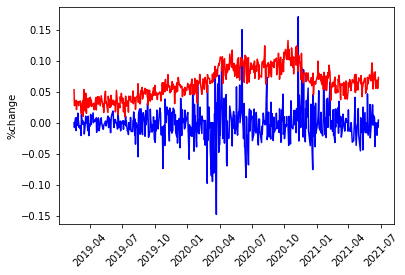

In [ ]:
seq_input,cat_input,target = next(iter(test_dl))

# model output
pred_pct = model_no_indicator(seq_input,cat_input)
inv_pred_pct = pred_pct*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
date_test = date_all[split:]

_=plt.plot(date_test[:],inv_true_pct.cpu().detach().numpy()[:],'b')
_=plt.plot(date_test[:],inv_pred_pct.cpu().detach().numpy()[:],'r')
_=plt.xticks(rotation=45)
_=plt.ylabel('%change')

In [ ]:
# convert to price plot
seq_input,cat_input,target = next(iter(test_dl))

# model output
pred_pct = model_no_indicator(seq_input,cat_input)
inv_pred_pct = pred_pct*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']

# to get real price is to multiply the predicted % with previous day close price
#edit changed seq_input[:,-1,-2] to seq_input[:,-1,-4]
prev_day_close = seq_input[:,-1,-2]*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
pred_price = (1+inv_pred_pct.view(-1,))*prev_day_close
inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
true_price = (1+inv_true_pct.view(-1,))*prev_day_close

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:680: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


In [ ]:
#grabs the same amount of real price as pred price 
n_days = list(pred_price.shape)
n_days = n_days[0]
n_days = -n_days
tensor_Close = torch.tensor(stock_data[0].iloc[n_days:,:]['Close'].values)
tensor_Close = tensor_Close.to(device)

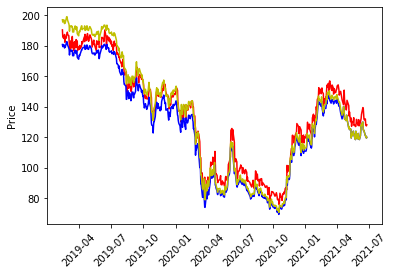

In [ ]:
#graph of predicted and true closing price 905 days
_=plt.plot(date_test[-905:],pred_price.cpu().detach().numpy()[-905:],'r') #Predict
_=plt.plot(date_test[-905:],true_price.cpu().detach().numpy()[-905:],'b') #True 
_=plt.plot(date_test[-905:],tensor_Close.cpu().detach().numpy()[-905:],'y') #Actual
_=plt.xticks(rotation=45)
_=plt.ylabel('Price')

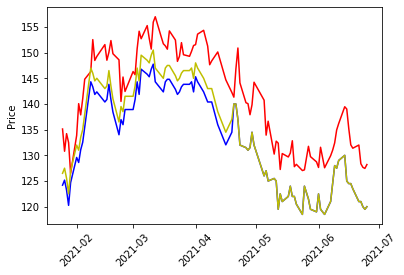

In [ ]:
#graph of predicted and true closing price 100 days
_=plt.plot(date_test[-100:],pred_price.cpu().detach().numpy()[-100:],'r') #Predict
_=plt.plot(date_test[-100:],true_price.cpu().detach().numpy()[-100:],'b') #True 
_=plt.plot(date_test[-100:],tensor_Close.cpu().detach().numpy()[-100:],'y') #Actual
_=plt.xticks(rotation=45)
_=plt.ylabel('Price')

In [ ]:
F.mse_loss(true_price,pred_price).sqrt() #comparing pred price to true price

tensor(8.1659, device='cuda:0', grad_fn=<SqrtBackward>)

In [ ]:
F.mse_loss(tensor_Close,pred_price).sqrt() #comparing pred price to true price

tensor(6.6718, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)

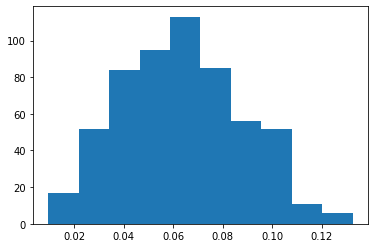

In [ ]:
_ = plt.hist(inv_pred_pct.cpu().detach().numpy().squeeze())

In [ ]:
y_pred = inv_pred_pct.cpu().detach().numpy().squeeze()
y_true = inv_true_pct.cpu().detach().numpy().squeeze()

In [ ]:
y_true_bin = (y_true > 0).astype(float) #if the change is more than 0% it will be displayed as 1
y_pred_bin = (y_pred > 0).astype(float)

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix

In [ ]:
print(classification_report(y_true_bin, y_pred_bin))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       324
         1.0       0.43      1.00      0.60       247

    accuracy                           0.43       571
   macro avg       0.22      0.50      0.30       571
weighted avg       0.19      0.43      0.26       571



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
F.mse_loss(true_price,pred_price).sqrt()

tensor(8.1659, device='cuda:0', grad_fn=<SqrtBackward>)